# Week 2b: Poisson Regression for Neural Spike Trains

This notebook introduces **Generalized Linear Models (GLMs)** for modeling neural
spike train data. We'll build up from simple models with discrete covariates to
more complex models with continuous covariates and flexible basis functions.

GLMs provide a principled framework for:
- Modeling count data (spike counts are non-negative integers)
- Quantifying relationships between firing rate and behavioral variables
- Comparing models with different covariates
- Obtaining confidence intervals on estimated firing rates

We continue using data from [Petersen & Buzsáki (2020)](https://pmc.ncbi.nlm.nih.gov/articles/PMC7442698/),
which investigated hippocampal place cells during spatial navigation.

## Learning Objectives

By the end of this notebook, you will be able to:

1. Understand why Poisson regression is appropriate for spike count data
2. Model firing rate with discrete covariates (direction) using indicator functions
3. Model firing rate with continuous 1D covariates (speed)
4. Discretize 2D position into bins and model with indicators
5. Use spline basis functions for smooth, flexible models
6. Combine multiple covariates (position, speed, direction)
7. Compare model predictions to raw data (rasters, histograms)

## Setup

In [1]:
# Install dependencies (required for Google Colab)
import subprocess
import sys

if "google.colab" in sys.modules:
    subprocess.check_call(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "-q",
            "pynwb",
            "hdmf",
            "dandi",
            "remfile",
            "h5py",
            "fsspec",
            "aiohttp",
            "requests",
            "statsmodels",
            "patsy",
        ]
    )

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from remfile import File as RemoteFile
from scipy.stats import chi2

## Load Data from DANDI

In [3]:
# Define the dataset location on DANDI
DANDISET_ID = "000059"
DANDISET_VERSION = "0.230907.2101"
ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb"
)

In [4]:
# Connect to DANDI and get the streaming URL
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    asset = dandiset.get_asset_by_path(ASSET_PATH)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"Streaming from: {s3_url[:80]}...")

Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/075/b32/075b32be-1c44-4e2f-8a91-3eeb...


In [5]:
# Open the NWB file for streaming
remote_file = RemoteFile(s3_url)
h5_file = h5py.File(remote_file, "r")
io = NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()

print(f"Session: {nwbfile.identifier}")

Session: 7931d1a7-09c5-457f-9f0a-22d952d8b818


## Extract Behavioral and Neural Data

In [6]:
# Get behavior data
behavior_module = nwbfile.processing["behavior"]

# Extract position
position_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "position" in name.lower()
)
spatial_series = next(iter(position_interface.spatial_series.values()))
position_data = spatial_series.data[:]
position_timestamps = spatial_series.timestamps[:]
x_position = position_data[:, 0]
y_position = position_data[:, 1]

# Extract speed
speed_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "speed" in name.lower()
)
speed_data = speed_interface.data[:]
speed_timestamps = speed_interface.timestamps[:]

print(f"Position time range: {position_timestamps[0]:.1f} - {position_timestamps[-1]:.1f} s")
print(f"X position range: {np.nanmin(x_position):.1f} - {np.nanmax(x_position):.1f} cm")
print(f"Y position range: {np.nanmin(y_position):.1f} - {np.nanmax(y_position):.1f} cm")

Position time range: 6348.1 - 8003.6 s
X position range: -49.4 - 57.5 cm
Y position range: -61.5 - 54.9 cm


In [7]:
# Select a good unit to analyze
units_df = nwbfile.units.to_dataframe()
good_unit_mask = units_df["quality"].isin(["good", "good2"])
good_unit_indices = np.where(good_unit_mask)[0]

# Choose a unit
unit_idx = good_unit_indices[3]
spike_times = nwbfile.units["spike_times"][unit_idx]

# Filter spikes to position tracking epoch
epoch_mask = (spike_times >= position_timestamps.min()) & (
    spike_times <= position_timestamps.max()
)
spike_times_epoch = spike_times[epoch_mask]

print(f"Unit {unit_idx}: {len(spike_times_epoch)} spikes during position tracking")

Unit 598: 677 spikes during position tracking


## Preparing Data for GLM

We need to:
1. Bin time into discrete intervals
2. Count spikes in each bin
3. Determine covariate values (position, speed, direction) for each bin

In [8]:
# Define time bins
BIN_SIZE = 0.025  # 25 ms bins (40 Hz)

bin_edges = np.arange(
    position_timestamps.min(), position_timestamps.max() + BIN_SIZE, BIN_SIZE
)
bin_centers = bin_edges[:-1] + BIN_SIZE / 2

# Count spikes in each bin
spike_counts, _ = np.histogram(spike_times_epoch, bins=bin_edges)

# Interpolate position and speed to bin centers
x_binned = np.interp(bin_centers, position_timestamps, x_position)
y_binned = np.interp(bin_centers, position_timestamps, y_position)
speed_binned = np.interp(bin_centers, speed_timestamps, speed_data)

# Compute movement direction from position gradient
x_gradient = np.gradient(x_binned)
direction = np.where(x_gradient > 0, "rightward", "leftward")

print(f"Number of time bins: {len(bin_centers)}")
print(f"Total spikes: {spike_counts.sum()}")
print(f"Mean spikes per bin: {spike_counts.mean():.3f}")

Number of time bins: 66218
Total spikes: 677
Mean spikes per bin: 0.010


In [9]:
# Create DataFrame for modeling
df = pd.DataFrame(
    {
        "spike_count": spike_counts,
        "time": bin_centers,
        "x_position": x_binned,
        "y_position": y_binned,
        "speed": speed_binned,
        "direction": pd.Categorical(direction),
    }
)

# Remove bins with missing data
df = df.dropna()
print(f"DataFrame shape after removing NaN: {df.shape}")
print(df.head())

DataFrame shape after removing NaN: (65691, 6)
   spike_count       time  x_position  y_position      speed direction
0            0  6348.1206  -10.555256  -48.316635  49.952718  leftward
1            0  6348.1456  -11.272324  -48.167795  50.401340  leftward
2            0  6348.1706  -12.023902  -48.026843  53.278398  leftward
3            0  6348.1956  -12.791517  -47.901963  54.603271  leftward
4            0  6348.2206  -13.561973  -47.798976  52.764293  leftward


## Why Poisson Regression?

Neural spike counts have specific properties that make ordinary linear regression
inappropriate:

1. **Non-negative**: Spike counts can't be negative
2. **Integer-valued**: We observe whole numbers of spikes
3. **Variance scales with mean**: Higher firing rates have higher variability

The **Poisson distribution** naturally captures these properties. For spike count
$n$ in a time bin with expected count $\lambda$:

$$P(n | \lambda) = \frac{\lambda^n e^{-\lambda}}{n!}$$

In Poisson regression (a type of GLM), we model the log of the expected count as
a linear function of covariates:

$$\log(\lambda) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots$$

The **log link function** ensures that $\lambda = \exp(\beta_0 + \beta_1 x_1 + \ldots)$
is always positive.

## Model 1: Constant Rate (Null Model)

We start with the simplest model: a constant firing rate. This serves as our
baseline for comparison.

$$\log(\lambda) = \beta_0$$

The coefficient $\beta_0$ represents the log of the mean spike count per bin.

In [10]:
# Fit constant rate model (intercept only)
model_constant = smf.glm("spike_count ~ 1", data=df, family=sm.families.Poisson())
results_constant = model_constant.fit()

print(results_constant.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            spike_count   No. Observations:                65691
Model:                            GLM   Df Residuals:                    65690
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3861.6
Date:                Fri, 06 Feb 2026   Deviance:                       6531.9
Time:                        14:47:05   Pearson chi2:                 9.12e+04
No. Iterations:                     7   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.5750      0.038   -119.039      0.0

In [11]:
# Interpret the coefficient
mean_count_per_bin = np.exp(results_constant.params["Intercept"])
mean_rate_hz = mean_count_per_bin / BIN_SIZE

print(f"β₀ = {results_constant.params['Intercept']:.4f}")
print(f"exp(β₀) = {mean_count_per_bin:.4f} spikes/bin")
print(f"Firing rate = {mean_rate_hz:.2f} Hz")
print(f"Observed mean = {df['spike_count'].mean():.4f} spikes/bin")

β₀ = -4.5750
exp(β₀) = 0.0103 spikes/bin
Firing rate = 0.41 Hz
Observed mean = 0.0103 spikes/bin


## Model 2: Direction as a Discrete Covariate

Now let's model how firing rate depends on movement direction. Direction is a
**categorical variable** with two levels: "leftward" and "rightward".

In GLM notation, we use **indicator functions** (also called dummy variables):

$$\log(\lambda) = \beta_0 + \beta_1 \cdot \mathbf{1}_{\text{rightward}}$$

where $\mathbf{1}_{\text{rightward}} = 1$ if moving rightward, 0 otherwise.

- When moving leftward: $\log(\lambda) = \beta_0$, so $\lambda = e^{\beta_0}$
- When moving rightward: $\log(\lambda) = \beta_0 + \beta_1$, so $\lambda = e^{\beta_0 + \beta_1}$

The coefficient $\beta_1$ represents the **log ratio** of firing rates:
$\beta_1 = \log(\lambda_{\text{right}} / \lambda_{\text{left}})$

### First, let's look at the raw data

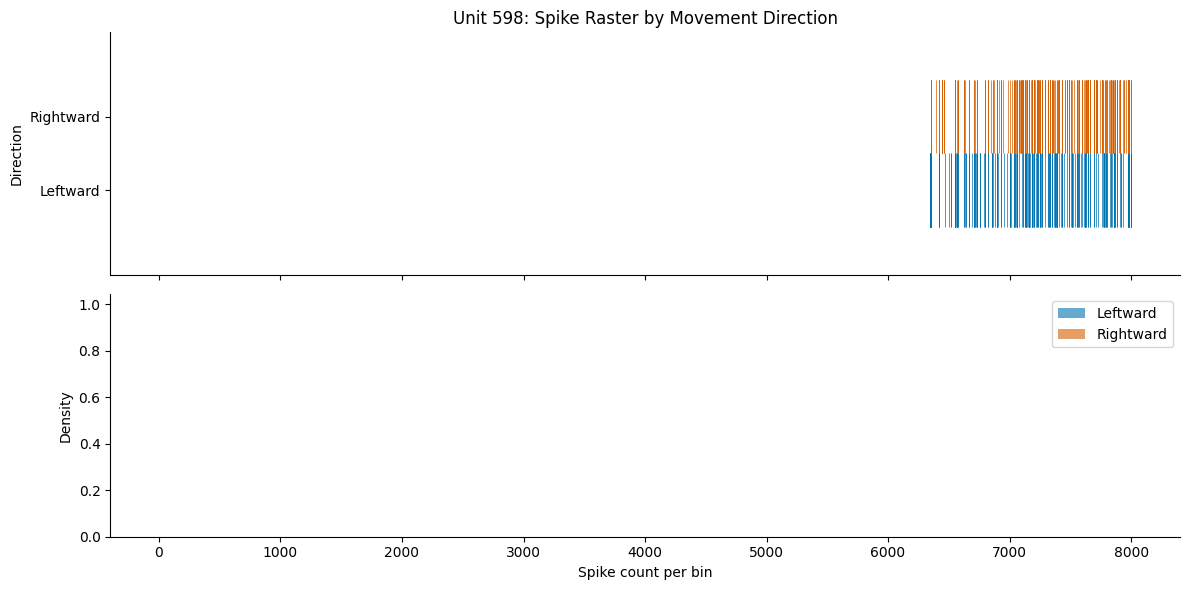

In [12]:
# Visualize spikes by direction with a raster plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Get spike times for each direction
leftward_bins = df[df["direction"] == "leftward"]["time"].values
rightward_bins = df[df["direction"] == "rightward"]["time"].values

# Find spikes that occurred during each direction
# Use a small window around each bin center
leftward_spikes = []
rightward_spikes = []

for t in spike_times_epoch[:5000]:  # First portion for visualization
    idx = np.searchsorted(bin_centers, t) - 1
    if 0 <= idx < len(direction):
        if direction[idx] == "leftward":
            leftward_spikes.append(t)
        else:
            rightward_spikes.append(t)

# Raster plot
ax = axes[0]
ax.eventplot([leftward_spikes[:500]], lineoffsets=0, colors="#0072B2", linewidths=0.5)
ax.eventplot([rightward_spikes[:500]], lineoffsets=1, colors="#D55E00", linewidths=0.5)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Leftward", "Rightward"])
ax.set_ylabel("Direction")
ax.set_title(f"Unit {unit_idx}: Spike Raster by Movement Direction")
ax.spines[["top", "right"]].set_visible(False)

# Histogram of spike counts by direction
ax = axes[1]
left_counts = df[df["direction"] == "leftward"]["spike_count"]
right_counts = df[df["direction"] == "rightward"]["spike_count"]

bins = np.arange(0, max(left_counts.max(), right_counts.max()) + 2) - 0.5
ax.hist(left_counts, bins=bins, alpha=0.6, label="Leftward", color="#0072B2", density=True)
ax.hist(right_counts, bins=bins, alpha=0.6, label="Rightward", color="#D55E00", density=True)
ax.set_xlabel("Spike count per bin")
ax.set_ylabel("Density")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

In [13]:
# Compare empirical firing rates
left_rate = left_counts.mean() / BIN_SIZE
right_rate = right_counts.mean() / BIN_SIZE

print("Empirical firing rates:")
print(f"  Leftward:  {left_rate:.2f} Hz")
print(f"  Rightward: {right_rate:.2f} Hz")
print(f"  Ratio (right/left): {right_rate / left_rate:.2f}")

Empirical firing rates:
  Leftward:  0.37 Hz
  Rightward: 0.45 Hz
  Ratio (right/left): 1.24


### Fit the direction model

In [14]:
# Fit model with direction
model_direction = smf.glm(
    "spike_count ~ direction", data=df, family=sm.families.Poisson()
)
results_direction = model_direction.fit()

print(results_direction.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            spike_count   No. Observations:                65691
Model:                            GLM   Df Residuals:                    65689
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3857.7
Date:                Fri, 06 Feb 2026   Deviance:                       6524.2
Time:                        14:47:05   Pearson chi2:                 9.07e+04
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0001180
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4

In [15]:
# Interpret coefficients
beta0 = results_direction.params["Intercept"]
beta1 = results_direction.params["direction[T.rightward]"]

rate_left = np.exp(beta0) / BIN_SIZE
rate_right = np.exp(beta0 + beta1) / BIN_SIZE

print("Model interpretation:")
print(f"  β₀ = {beta0:.4f} (log rate when leftward)")
print(f"  β₁ = {beta1:.4f} (log ratio rightward/leftward)")
print()
print("Estimated firing rates:")
print(f"  Leftward:  {rate_left:.2f} Hz")
print(f"  Rightward: {rate_right:.2f} Hz")
print(f"  Ratio: exp(β₁) = {np.exp(beta1):.2f}")

Model interpretation:
  β₀ = -4.6938 (log rate when leftward)
  β₁ = 0.2156 (log ratio rightward/leftward)

Estimated firing rates:
  Leftward:  0.37 Hz
  Rightward: 0.45 Hz
  Ratio: exp(β₁) = 1.24


In [16]:
# Get confidence intervals on firing rates
# Use get_prediction for proper uncertainty quantification
pred_df = pd.DataFrame({"direction": pd.Categorical(["leftward", "rightward"])})
predictions = results_direction.get_prediction(pred_df)

pred_summary = predictions.summary_frame()
pred_summary["rate_hz"] = pred_summary["mean"] / BIN_SIZE
pred_summary["rate_ci_lower"] = pred_summary["mean_ci_lower"] / BIN_SIZE
pred_summary["rate_ci_upper"] = pred_summary["mean_ci_upper"] / BIN_SIZE
pred_summary.index = ["Leftward", "Rightward"]

print("\nFiring rates with 95% confidence intervals:")
print(pred_summary[["rate_hz", "rate_ci_lower", "rate_ci_upper"]])


Firing rates with 95% confidence intervals:
            rate_hz  rate_ci_lower  rate_ci_upper
Leftward   0.366057       0.325999       0.411037
Rightward  0.454136       0.411281       0.501457


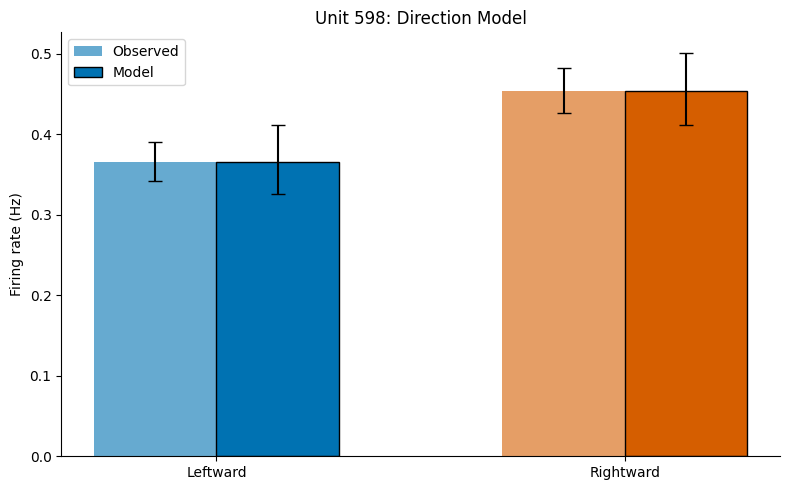

In [17]:
# Visualize model predictions vs observed data
fig, ax = plt.subplots(figsize=(8, 5))

x_pos = [0, 1]
colors = ["#0072B2", "#D55E00"]

# Observed rates (with standard error)
observed_rates = [left_rate, right_rate]
observed_se = [
    left_counts.std() / np.sqrt(len(left_counts)) / BIN_SIZE,
    right_counts.std() / np.sqrt(len(right_counts)) / BIN_SIZE,
]

# Plot observed
ax.bar(
    [p - 0.15 for p in x_pos],
    observed_rates,
    width=0.3,
    color=colors,
    alpha=0.6,
    label="Observed",
    yerr=observed_se,
    capsize=5,
)

# Plot model predictions with CI
model_rates = pred_summary["rate_hz"].values
model_ci_lower = pred_summary["rate_ci_lower"].values
model_ci_upper = pred_summary["rate_ci_upper"].values
yerr = [model_rates - model_ci_lower, model_ci_upper - model_rates]

ax.bar(
    [p + 0.15 for p in x_pos],
    model_rates,
    width=0.3,
    color=colors,
    alpha=1.0,
    label="Model",
    yerr=yerr,
    capsize=5,
    edgecolor="black",
)

ax.set_xticks(x_pos)
ax.set_xticklabels(["Leftward", "Rightward"])
ax.set_ylabel("Firing rate (Hz)")
ax.set_title(f"Unit {unit_idx}: Direction Model")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

### Model comparison: Does direction matter?

In [18]:
# Compare AICs
print("Model Comparison")
print("-" * 40)
print(f"Constant model AIC: {results_constant.aic:.1f}")
print(f"Direction model AIC: {results_direction.aic:.1f}")
print(f"ΔAIC: {results_direction.aic - results_constant.aic:.1f}")

# Likelihood ratio test
lr_stat = 2 * (results_direction.llf - results_constant.llf)
p_value = chi2.sf(lr_stat, df=1)
print(f"\nLikelihood ratio test: χ² = {lr_stat:.2f}, p = {p_value:.2e}")

Model Comparison
----------------------------------------
Constant model AIC: 7725.2
Direction model AIC: 7719.5
ΔAIC: -5.8

Likelihood ratio test: χ² = 7.75, p = 5.37e-03


## Model 3: Speed as a Continuous Covariate

Speed is a continuous variable, so we model it directly:

$$\log(\lambda) = \beta_0 + \beta_1 \cdot \text{speed}$$

The coefficient $\beta_1$ represents the change in log firing rate per unit
increase in speed (cm/s). In multiplicative terms:
- A 1 cm/s increase in speed multiplies the firing rate by $e^{\beta_1}$

### Visualize raw data: spikes vs speed

In [19]:
# Create speed bins for visualization
speed_bins = np.linspace(0, df["speed"].quantile(0.99), 20)
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# Compute spike rate in each speed bin (histogram approach)
speed_bin_idx = np.digitize(df["speed"], speed_bins) - 1
valid_bins = (speed_bin_idx >= 0) & (speed_bin_idx < len(speed_bin_centers))

spike_rate_by_speed = []
spike_rate_se = []
occupancy = []

for i in range(len(speed_bin_centers)):
    mask = speed_bin_idx == i
    if mask.sum() > 10:  # Need enough samples
        counts = df.loc[mask, "spike_count"]
        rate = counts.mean() / BIN_SIZE
        se = counts.std() / np.sqrt(mask.sum()) / BIN_SIZE
        spike_rate_by_speed.append(rate)
        spike_rate_se.append(se)
        occupancy.append(mask.sum())
    else:
        spike_rate_by_speed.append(np.nan)
        spike_rate_se.append(np.nan)
        occupancy.append(0)

spike_rate_by_speed = np.array(spike_rate_by_speed)
spike_rate_se = np.array(spike_rate_se)

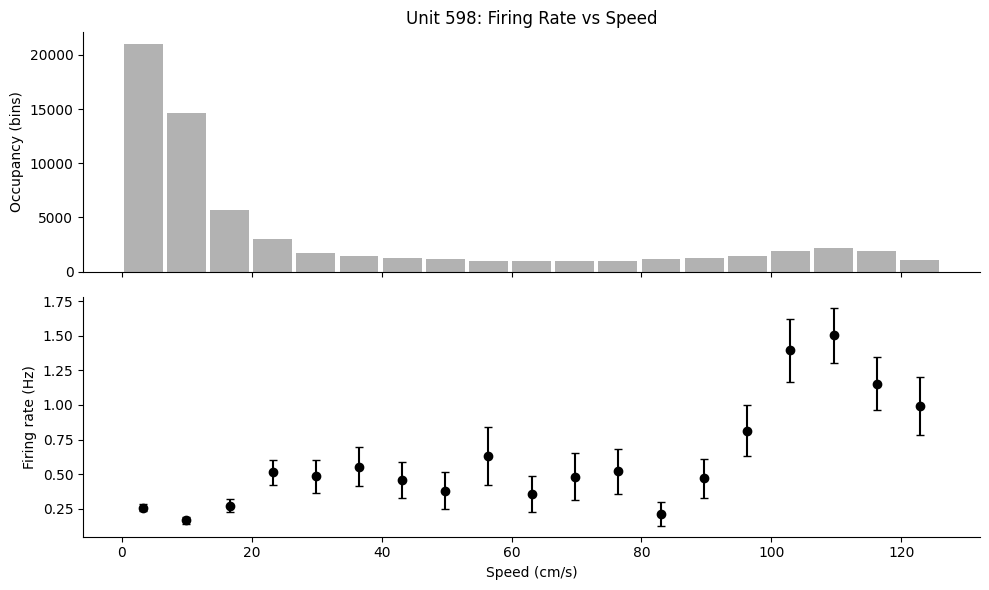

In [20]:
# Plot firing rate vs speed (histogram method)
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Occupancy
ax = axes[0]
ax.bar(speed_bin_centers, occupancy, width=np.diff(speed_bins)[0] * 0.9, color="gray", alpha=0.6)
ax.set_ylabel("Occupancy (bins)")
ax.set_title(f"Unit {unit_idx}: Firing Rate vs Speed")
ax.spines[["top", "right"]].set_visible(False)

# Firing rate with error bars
ax = axes[1]
valid = ~np.isnan(spike_rate_by_speed)
ax.errorbar(
    speed_bin_centers[valid],
    spike_rate_by_speed[valid],
    yerr=spike_rate_se[valid],
    fmt="o",
    color="black",
    markersize=6,
    capsize=3,
    label="Observed (binned)",
)
ax.set_xlabel("Speed (cm/s)")
ax.set_ylabel("Firing rate (Hz)")
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

### Fit the speed model

In [21]:
# Fit linear speed model
model_speed = smf.glm("spike_count ~ speed", data=df, family=sm.families.Poisson())
results_speed = model_speed.fit()

print(results_speed.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            spike_count   No. Observations:                65691
Model:                            GLM   Df Residuals:                    65689
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3732.0
Date:                Fri, 06 Feb 2026   Deviance:                       6272.7
Time:                        14:47:06   Pearson chi2:                 8.68e+04
No. Iterations:                     8   Pseudo R-squ. (CS):           0.003938
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.1834      0.061    -84.573      0.0

In [22]:
# Interpret coefficients
beta0_speed = results_speed.params["Intercept"]
beta1_speed = results_speed.params["speed"]

print("Model interpretation:")
print(f"  β₀ = {beta0_speed:.4f} (log rate at speed=0)")
print(f"  β₁ = {beta1_speed:.5f} (change in log rate per cm/s)")
print()
print(f"At speed=0: rate = {np.exp(beta0_speed) / BIN_SIZE:.2f} Hz")
print(f"At speed=20: rate = {np.exp(beta0_speed + beta1_speed * 20) / BIN_SIZE:.2f} Hz")
print(f"Effect: {100 * (np.exp(beta1_speed) - 1):.2f}% change per 1 cm/s")

Model interpretation:
  β₀ = -5.1834 (log rate at speed=0)
  β₁ = 0.01376 (change in log rate per cm/s)

At speed=0: rate = 0.22 Hz
At speed=20: rate = 0.30 Hz
Effect: 1.39% change per 1 cm/s


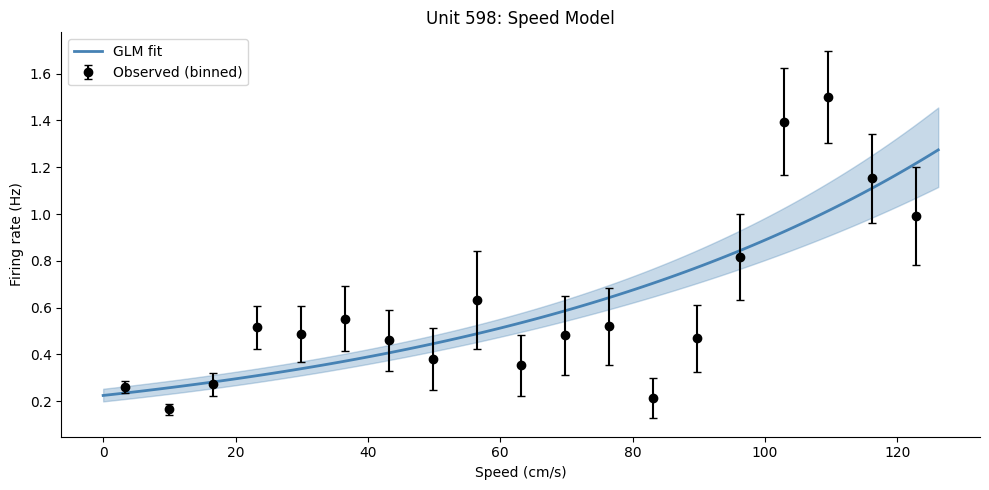

In [23]:
# Plot model predictions with confidence intervals
speed_grid = np.linspace(0, df["speed"].quantile(0.99), 100)
pred_df_speed = pd.DataFrame({"speed": speed_grid})

predictions_speed = results_speed.get_prediction(pred_df_speed)
pred_mean = predictions_speed.predicted_mean / BIN_SIZE
pred_ci = predictions_speed.conf_int() / BIN_SIZE

fig, ax = plt.subplots(figsize=(10, 5))

# Observed data points
ax.errorbar(
    speed_bin_centers[valid],
    spike_rate_by_speed[valid],
    yerr=spike_rate_se[valid],
    fmt="o",
    color="black",
    markersize=6,
    capsize=3,
    label="Observed (binned)",
    zorder=5,
)

# Model fit with CI
ax.fill_between(speed_grid, pred_ci[:, 0], pred_ci[:, 1], alpha=0.3, color="steelblue")
ax.plot(speed_grid, pred_mean, color="steelblue", linewidth=2, label="GLM fit")

ax.set_xlabel("Speed (cm/s)")
ax.set_ylabel("Firing rate (Hz)")
ax.set_title(f"Unit {unit_idx}: Speed Model")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

In [24]:
# Compare to constant model
print("Model Comparison")
print("-" * 40)
print(f"Constant model AIC: {results_constant.aic:.1f}")
print(f"Speed model AIC: {results_speed.aic:.1f}")
print(f"ΔAIC: {results_speed.aic - results_constant.aic:.1f}")

lr_stat = 2 * (results_speed.llf - results_constant.llf)
p_value = chi2.sf(lr_stat, df=1)
print(f"\nLikelihood ratio test: χ² = {lr_stat:.2f}, p = {p_value:.2e}")

Model Comparison
----------------------------------------
Constant model AIC: 7725.2
Speed model AIC: 7468.0
ΔAIC: -257.2

Likelihood ratio test: χ² = 259.20, p = 2.56e-58


## Model 4: Position with Indicator Functions (Discretized)

For position, we could use polynomial functions, but let's first use
**indicator functions** - the same approach we used for direction, but with
many levels.

We discretize position into bins and create an indicator for each bin:

$$\log(\lambda) = \beta_0 + \beta_1 \mathbf{1}_{x \in \text{bin}_1} + \beta_2 \mathbf{1}_{x \in \text{bin}_2} + \ldots$$

This is flexible but requires estimating many parameters (one per bin).

### First, visualize the place field with histogram approach

In [25]:
# Create 2D position bins
N_POS_BINS = 15  # Number of bins per dimension

x_edges = np.linspace(np.nanmin(x_position), np.nanmax(x_position), N_POS_BINS + 1)
y_edges = np.linspace(np.nanmin(y_position), np.nanmax(y_position), N_POS_BINS + 1)

# Compute occupancy and spike counts
occupancy_2d, _, _ = np.histogram2d(df["x_position"], df["y_position"], bins=[x_edges, y_edges])

# Weight by spike counts for spike map
spike_map = np.zeros_like(occupancy_2d)
for i, row in df.iterrows():
    x_idx = np.clip(np.searchsorted(x_edges, row["x_position"]) - 1, 0, N_POS_BINS - 1)
    y_idx = np.clip(np.searchsorted(y_edges, row["y_position"]) - 1, 0, N_POS_BINS - 1)
    spike_map[x_idx, y_idx] += row["spike_count"]

# Compute firing rate (occupancy normalized)
with np.errstate(divide="ignore", invalid="ignore"):
    rate_map = spike_map / occupancy_2d / BIN_SIZE
    rate_map[~np.isfinite(rate_map)] = np.nan

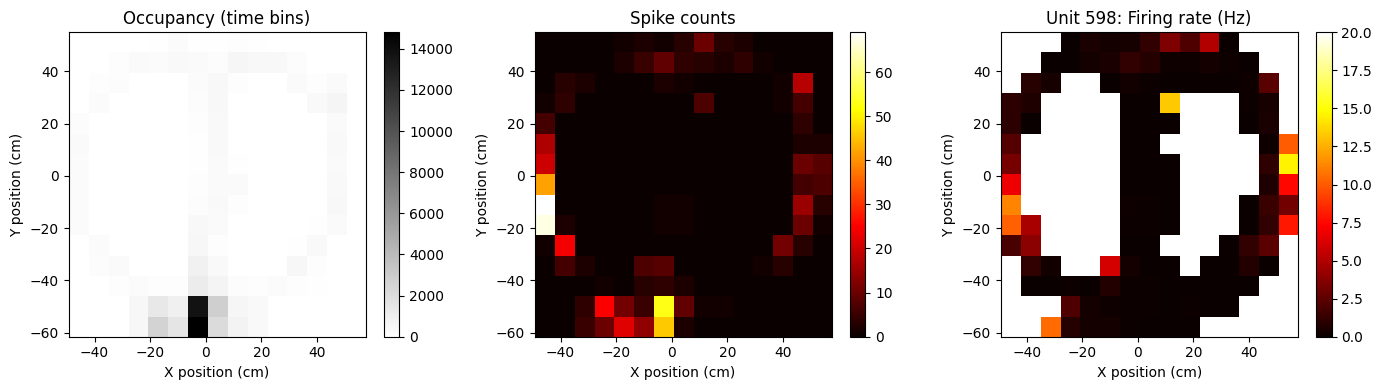

In [26]:
# Plot the place field
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Occupancy
ax = axes[0]
im = ax.imshow(
    occupancy_2d.T,
    origin="lower",
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
    aspect="auto",
    cmap="gray_r",
)
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Occupancy (time bins)")
plt.colorbar(im, ax=ax)

# Spike counts
ax = axes[1]
im = ax.imshow(
    spike_map.T,
    origin="lower",
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
    aspect="auto",
    cmap="hot",
)
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Spike counts")
plt.colorbar(im, ax=ax)

# Firing rate
ax = axes[2]
im = ax.imshow(
    rate_map.T,
    origin="lower",
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
    aspect="auto",
    cmap="hot",
)
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title(f"Unit {unit_idx}: Firing rate (Hz)")
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

### Create position bin indicators

In [27]:
# Discretize position into bins for GLM
N_BINS_GLM = 10  # Fewer bins to avoid overfitting

x_bin_edges = np.linspace(np.nanmin(x_position), np.nanmax(x_position), N_BINS_GLM + 1)
y_bin_edges = np.linspace(np.nanmin(y_position), np.nanmax(y_position), N_BINS_GLM + 1)

# Assign each time bin to a position bin
df["x_bin"] = pd.cut(df["x_position"], bins=x_bin_edges, labels=False, include_lowest=True)
df["y_bin"] = pd.cut(df["y_position"], bins=y_bin_edges, labels=False, include_lowest=True)

# Create combined position bin label
df["pos_bin"] = df["x_bin"].astype(str) + "_" + df["y_bin"].astype(str)
df["pos_bin"] = pd.Categorical(df["pos_bin"])

print(f"Number of unique position bins: {df['pos_bin'].nunique()}")
print(f"Position bins with data: {df.groupby('pos_bin').size().gt(0).sum()}")

Number of unique position bins: 66
Position bins with data: 66


/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_20925/2123366585.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f"Position bins with data: {df.groupby('pos_bin').size().gt(0).sum()}")


### Fit the position indicator model

In [28]:
# Fit model with position indicators
# C() tells patsy to treat as categorical
model_pos_ind = smf.glm(
    "spike_count ~ C(pos_bin)", data=df, family=sm.families.Poisson()
)
results_pos_ind = model_pos_ind.fit()

print(f"Number of parameters: {len(results_pos_ind.params)}")
print(f"AIC: {results_pos_ind.aic:.1f}")

Number of parameters: 66
AIC: 6286.4


In [29]:
# Reconstruct the rate map from model coefficients
rate_map_glm = np.full((N_BINS_GLM, N_BINS_GLM), np.nan)

# Get predictions for each position bin
for x_idx in range(N_BINS_GLM):
    for y_idx in range(N_BINS_GLM):
        pos_label = f"{x_idx}_{y_idx}"
        mask = df["pos_bin"] == pos_label
        if mask.sum() > 0:
            # Get prediction for this bin
            pred_df = pd.DataFrame({"pos_bin": pd.Categorical([pos_label], categories=df["pos_bin"].cat.categories)})
            pred = results_pos_ind.get_prediction(pred_df)
            rate_map_glm[x_idx, y_idx] = pred.predicted_mean[0] / BIN_SIZE

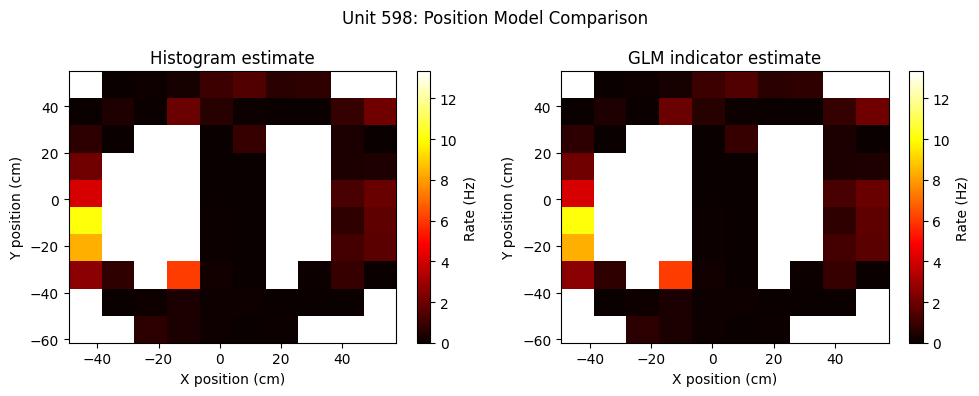

In [30]:
# Compare histogram and GLM rate maps
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Use same bins for fair comparison
x_edges_glm = x_bin_edges
y_edges_glm = y_bin_edges

# Recompute histogram rate map at GLM resolution
occupancy_glm, _, _ = np.histogram2d(df["x_position"], df["y_position"], bins=[x_edges_glm, y_edges_glm])
spike_map_glm_hist = np.zeros((N_BINS_GLM, N_BINS_GLM))
for i, row in df.iterrows():
    x_idx = np.clip(int(row["x_bin"]), 0, N_BINS_GLM - 1)
    y_idx = np.clip(int(row["y_bin"]), 0, N_BINS_GLM - 1)
    spike_map_glm_hist[x_idx, y_idx] += row["spike_count"]

with np.errstate(divide="ignore", invalid="ignore"):
    rate_map_hist = spike_map_glm_hist / occupancy_glm / BIN_SIZE
    rate_map_hist[~np.isfinite(rate_map_hist)] = np.nan

# Same color scale for both
vmax = np.nanmax([np.nanmax(rate_map_hist), np.nanmax(rate_map_glm)])

ax = axes[0]
im = ax.imshow(
    rate_map_hist.T,
    origin="lower",
    extent=[x_edges_glm[0], x_edges_glm[-1], y_edges_glm[0], y_edges_glm[-1]],
    aspect="auto",
    cmap="hot",
    vmin=0,
    vmax=vmax,
)
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Histogram estimate")
plt.colorbar(im, ax=ax, label="Rate (Hz)")

ax = axes[1]
im = ax.imshow(
    rate_map_glm.T,
    origin="lower",
    extent=[x_edges_glm[0], x_edges_glm[-1], y_edges_glm[0], y_edges_glm[-1]],
    aspect="auto",
    cmap="hot",
    vmin=0,
    vmax=vmax,
)
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("GLM indicator estimate")
plt.colorbar(im, ax=ax, label="Rate (Hz)")

fig.suptitle(f"Unit {unit_idx}: Position Model Comparison", fontsize=12)
plt.tight_layout()
plt.show()

The indicator model gives similar results to the histogram approach - both are
essentially computing the mean firing rate in each bin. The advantage of GLM
is that we get confidence intervals and can combine with other covariates.

## Model 5: Smooth Position with Splines

Indicator functions are flexible but:
- Require many parameters (one per bin)
- Don't impose smoothness across adjacent bins
- Don't generalize well to new positions

**Spline basis functions** provide smooth, flexible fits with fewer parameters.
The `patsy` library provides:
- `bs(x, df=n)`: B-splines with `n` degrees of freedom
- `cr(x, df=n)`: Natural cubic regression splines

For 2D position, we use a **tensor product** of 1D splines.

In [31]:
# Fit 1D spline model for x position only
model_x_spline = smf.glm(
    "spike_count ~ bs(x_position, df=8)",
    data=df,
    family=sm.families.Poisson(),
)
results_x_spline = model_x_spline.fit()

print(f"Number of parameters: {len(results_x_spline.params)}")
print(f"AIC: {results_x_spline.aic:.1f}")

Number of parameters: 9
AIC: 6506.9


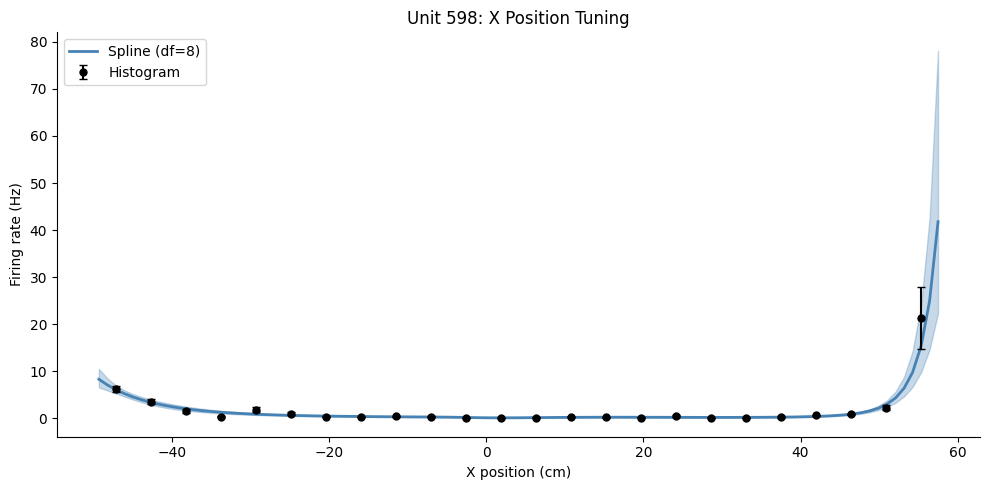

In [32]:
# Visualize 1D x-position tuning
x_grid = np.linspace(df["x_position"].min(), df["x_position"].max(), 100)
pred_df_x = pd.DataFrame({"x_position": x_grid})

predictions_x = results_x_spline.get_prediction(pred_df_x)
pred_mean_x = predictions_x.predicted_mean / BIN_SIZE
pred_ci_x = predictions_x.conf_int() / BIN_SIZE

# Compute histogram estimate for comparison
x_hist_edges = np.linspace(df["x_position"].min(), df["x_position"].max(), 25)
x_hist_centers = (x_hist_edges[:-1] + x_hist_edges[1:]) / 2
x_bin_assign = np.digitize(df["x_position"], x_hist_edges) - 1

rate_by_x = []
rate_se_x = []
for i in range(len(x_hist_centers)):
    mask = x_bin_assign == i
    if mask.sum() > 10:
        counts = df.loc[mask, "spike_count"]
        rate_by_x.append(counts.mean() / BIN_SIZE)
        rate_se_x.append(counts.std() / np.sqrt(mask.sum()) / BIN_SIZE)
    else:
        rate_by_x.append(np.nan)
        rate_se_x.append(np.nan)

fig, ax = plt.subplots(figsize=(10, 5))

# Histogram estimate
valid = ~np.isnan(rate_by_x)
ax.errorbar(
    np.array(x_hist_centers)[valid],
    np.array(rate_by_x)[valid],
    yerr=np.array(rate_se_x)[valid],
    fmt="o",
    color="black",
    markersize=5,
    capsize=3,
    label="Histogram",
    zorder=5,
)

# Spline fit with CI
ax.fill_between(x_grid, pred_ci_x[:, 0], pred_ci_x[:, 1], alpha=0.3, color="steelblue")
ax.plot(x_grid, pred_mean_x, color="steelblue", linewidth=2, label="Spline (df=8)")

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Firing rate (Hz)")
ax.set_title(f"Unit {unit_idx}: X Position Tuning")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

In [33]:
# Fit 2D spline model (tensor product of x and y splines)
model_xy_spline = smf.glm(
    "spike_count ~ bs(x_position, df=5) * bs(y_position, df=5)",
    data=df,
    family=sm.families.Poisson(),
)
results_xy_spline = model_xy_spline.fit()

print(f"Number of parameters: {len(results_xy_spline.params)}")
print(f"AIC: {results_xy_spline.aic:.1f}")

/Users/edeno/Documents/GitHub/ncbs-neural-circuits-navigation/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/edeno/Documents/GitHub/ncbs-neural-circuits-navigation/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/Users/edeno/Documents/GitHub/ncbs-neural-circuits-navigation/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:447: RuntimeWarning: overflow encountered in multiply
  return 2 * resid_dev
/Users/edeno/Documents/GitHub/ncbs-neural-circuits-navigation/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/Users/edeno/Documents/GitHub/ncbs-neural-circuits-navigation/.venv/lib/python3.13/site-packages/statsmodels/

ValueError: NaN, inf or invalid value detected in weights, estimation infeasible.

In [ ]:
# Generate predictions on a grid
n_grid = 30
x_grid_2d = np.linspace(df["x_position"].min(), df["x_position"].max(), n_grid)
y_grid_2d = np.linspace(df["y_position"].min(), df["y_position"].max(), n_grid)
xx, yy = np.meshgrid(x_grid_2d, y_grid_2d)

pred_df_2d = pd.DataFrame({
    "x_position": xx.ravel(),
    "y_position": yy.ravel(),
})

predictions_2d = results_xy_spline.get_prediction(pred_df_2d)
rate_pred_2d = predictions_2d.predicted_mean.reshape(n_grid, n_grid) / BIN_SIZE
rate_ci_lower = predictions_2d.conf_int()[:, 0].reshape(n_grid, n_grid) / BIN_SIZE
rate_ci_upper = predictions_2d.conf_int()[:, 1].reshape(n_grid, n_grid) / BIN_SIZE

In [ ]:
# Plot 2D spline place field with uncertainty
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Mean prediction
ax = axes[0]
im = ax.imshow(
    rate_pred_2d.T,
    origin="lower",
    extent=[x_grid_2d[0], x_grid_2d[-1], y_grid_2d[0], y_grid_2d[-1]],
    aspect="auto",
    cmap="hot",
)
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Spline estimate (mean)")
plt.colorbar(im, ax=ax, label="Rate (Hz)")

# CI width (uncertainty)
ci_width = rate_ci_upper - rate_ci_lower
ax = axes[1]
im = ax.imshow(
    ci_width.T,
    origin="lower",
    extent=[x_grid_2d[0], x_grid_2d[-1], y_grid_2d[0], y_grid_2d[-1]],
    aspect="auto",
    cmap="viridis",
)
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("95% CI width")
plt.colorbar(im, ax=ax, label="Hz")

# Compare to histogram
ax = axes[2]
im = ax.imshow(
    rate_map.T,
    origin="lower",
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
    aspect="auto",
    cmap="hot",
)
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Histogram estimate")
plt.colorbar(im, ax=ax, label="Rate (Hz)")

fig.suptitle(f"Unit {unit_idx}: 2D Spline Place Field", fontsize=12)
plt.tight_layout()
plt.show()

## Model 6: Combining Covariates

The real power of GLMs comes from combining multiple covariates. Let's build
a model with position, speed, and direction:

$$\log(\lambda) = \text{spline}(x, y) + \beta_{\text{speed}} \cdot \text{speed} + \beta_{\text{dir}} \cdot \mathbf{1}_{\text{rightward}}$$

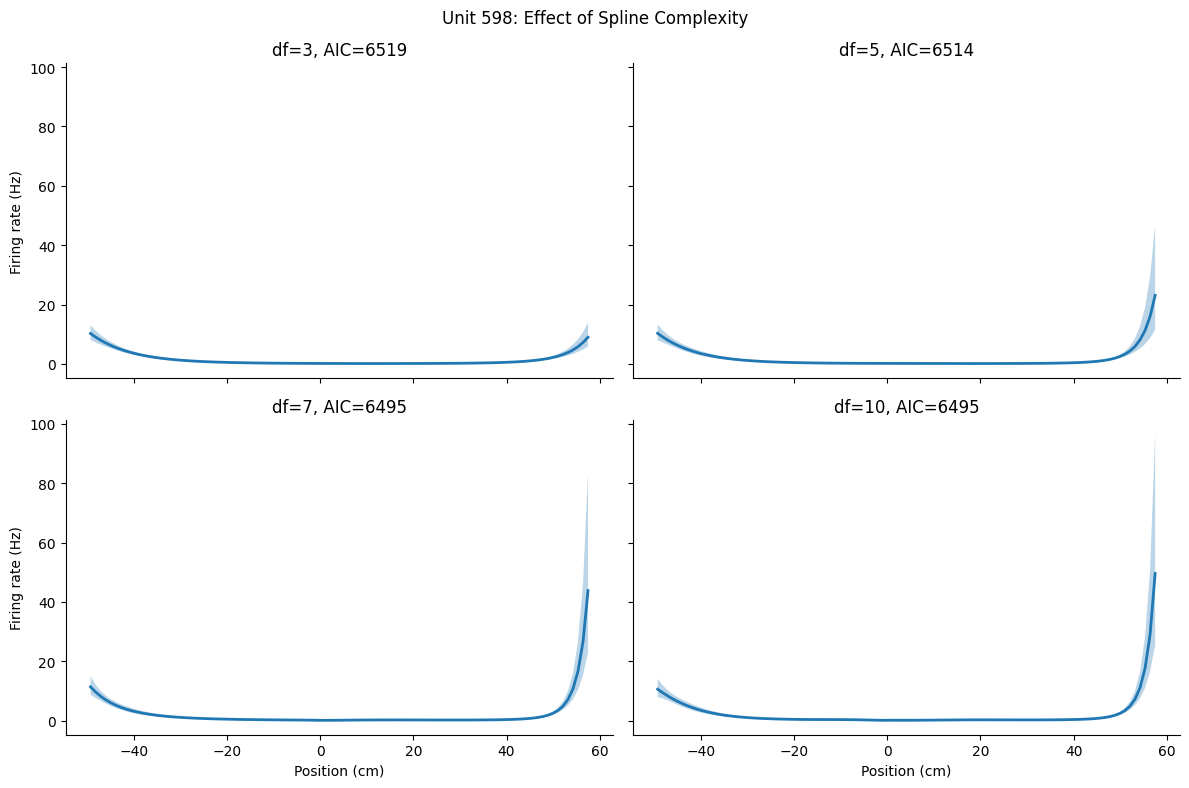

In [ ]:
# Fit full model
model_full = smf.glm(
    "spike_count ~ bs(x_position, df=5) * bs(y_position, df=5) + speed + direction",
    data=df,
    family=sm.families.Poisson(),
)
results_full = model_full.fit()

print(f"Number of parameters: {len(results_full.params)}")
print(f"AIC: {results_full.aic:.1f}")

In [ ]:
# Extract and interpret speed and direction effects
print("Covariate effects:")
print("-" * 40)

# Speed effect
speed_coef = results_full.params["speed"]
speed_ci = results_full.conf_int().loc["speed"]
print(f"Speed: β = {speed_coef:.4f} ({speed_ci[0]:.4f}, {speed_ci[1]:.4f})")
print(f"  → {100 * (np.exp(speed_coef) - 1):.2f}% change per 1 cm/s")

# Direction effect
dir_coef = results_full.params["direction[T.rightward]"]
dir_ci = results_full.conf_int().loc["direction[T.rightward]"]
print(f"\nDirection: β = {dir_coef:.4f} ({dir_ci[0]:.4f}, {dir_ci[1]:.4f})")
print(f"  → {100 * (np.exp(dir_coef) - 1):.2f}% change for rightward vs leftward")

In [ ]:
# Compare place fields for different conditions
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

conditions = [
    ("Leftward, slow", "leftward", 5),
    ("Rightward, slow", "rightward", 5),
    ("Leftward, fast", "leftward", 30),
    ("Rightward, fast", "rightward", 30),
]

vmax = 0  # Find common color scale
rate_maps = []

for title, dir_val, speed_val in conditions:
    pred_df_cond = pd.DataFrame({
        "x_position": xx.ravel(),
        "y_position": yy.ravel(),
        "speed": np.full(xx.size, speed_val),
        "direction": pd.Categorical([dir_val] * xx.size, categories=["leftward", "rightward"]),
    })
    predictions_cond = results_full.get_prediction(pred_df_cond)
    rate_map_cond = predictions_cond.predicted_mean.reshape(n_grid, n_grid) / BIN_SIZE
    rate_maps.append(rate_map_cond)
    vmax = max(vmax, np.nanmax(rate_map_cond))

for ax, (title, _, _), rate_map_cond in zip(axes.flat, conditions, rate_maps):
    im = ax.imshow(
        rate_map_cond.T,
        origin="lower",
        extent=[x_grid_2d[0], x_grid_2d[-1], y_grid_2d[0], y_grid_2d[-1]],
        aspect="auto",
        cmap="hot",
        vmin=0,
        vmax=vmax,
    )
    ax.set_xlabel("X position (cm)")
    ax.set_ylabel("Y position (cm)")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Rate (Hz)")

fig.suptitle(f"Unit {unit_idx}: Full Model Predictions", fontsize=12)
plt.tight_layout()
plt.show()

## Model Comparison Summary

In [ ]:
# Collect all models
models = [
    ("Constant", results_constant),
    ("Direction only", results_direction),
    ("Speed only", results_speed),
    ("Position (indicators)", results_pos_ind),
    ("X position (spline)", results_x_spline),
    ("XY position (spline)", results_xy_spline),
    ("Full (XY + speed + dir)", results_full),
]

print("Model Comparison")
print("=" * 65)
print(f"{'Model':<30} {'Params':>8} {'AIC':>12} {'Log-Lik':>12}")
print("-" * 65)
for name, results in models:
    print(f"{name:<30} {len(results.params):>8} {results.aic:>12.1f} {results.llf:>12.1f}")
print("=" * 65)

# Find best by AIC
best_idx = np.argmin([m[1].aic for m in models])
print(f"\nBest model by AIC: {models[best_idx][0]}")

Model with Direction (Additive)
                 Generalized Linear Model Regression Results                  
Dep. Variable:            spike_count   No. Observations:                65691
Model:                            GLM   Df Residuals:                    65683
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3244.0
Date:                Fri, 06 Feb 2026   Deviance:                       5296.8
Time:                        14:23:57   Pearson chi2:                 8.68e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01863
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

## Goodness-of-Fit: Comparing to Raw Data

Let's visualize how well our best model captures the observed firing patterns.

In [ ]:
# Get fitted rates from the full model
fitted_rates = results_full.fittedvalues / BIN_SIZE

# Compare observed vs predicted
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot of observed vs predicted (binned for clarity)
ax = axes[0]
# Bin by predicted rate
pred_bins = np.linspace(0, np.percentile(fitted_rates, 99), 20)
pred_bin_centers = (pred_bins[:-1] + pred_bins[1:]) / 2
pred_bin_idx = np.digitize(fitted_rates, pred_bins) - 1

obs_mean = []
obs_se = []
for i in range(len(pred_bin_centers)):
    mask = pred_bin_idx == i
    if mask.sum() > 20:
        obs = df.loc[mask, "spike_count"] / BIN_SIZE
        obs_mean.append(obs.mean())
        obs_se.append(obs.std() / np.sqrt(mask.sum()))
    else:
        obs_mean.append(np.nan)
        obs_se.append(np.nan)

valid = ~np.isnan(obs_mean)
ax.errorbar(
    np.array(pred_bin_centers)[valid],
    np.array(obs_mean)[valid],
    yerr=np.array(obs_se)[valid],
    fmt="o",
    color="black",
    capsize=3,
)
ax.plot([0, max(pred_bin_centers)], [0, max(pred_bin_centers)], "r--", label="Perfect prediction")
ax.set_xlabel("Predicted rate (Hz)")
ax.set_ylabel("Observed rate (Hz)")
ax.set_title("Model Calibration")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

# Residual distribution
ax = axes[1]
residuals = df["spike_count"] - results_full.fittedvalues
ax.hist(residuals, bins=50, density=True, alpha=0.7, color="steelblue")
ax.axvline(0, color="red", linestyle="--")
ax.set_xlabel("Residual (observed - predicted)")
ax.set_ylabel("Density")
ax.set_title("Residual Distribution")
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()


Model Comparison
----------------------------------------
Without direction:     AIC = 6514.0
Additive direction:    AIC = 6504.0
Interaction direction: AIC = 6423.3


## Exercises

Try these on your own to deepen your understanding:

1. **Different units**: Change `good_unit_indices[3]` to analyze a different
   unit. Do all units show the same covariate effects?

2. **Spline complexity**: Try different values for the spline `df` parameter
   (3, 5, 8, 12). How does AIC change?

3. **Speed × direction interaction**: Add `speed * direction` to the model.
   Does speed have a different effect for leftward vs rightward movement?

4. **Different bin sizes**: Try `BIN_SIZE = 0.01` (10 ms) and `BIN_SIZE = 0.1`
   (100 ms). How do the results change?

5. **Cross-validation**: Split data into first and second half. Fit on first
   half, evaluate log-likelihood on second half. Which model generalizes best?

6. **Natural splines**: Replace `bs()` with `cr()` (natural cubic splines).
   Does this change the predictions at the boundaries?

## Summary

In this notebook, we learned how to:

1. **Use Poisson regression** for spike count data
2. **Model discrete covariates** with indicator functions (direction)
3. **Model continuous covariates** directly (speed)
4. **Discretize position** and use indicators for place fields
5. **Use splines** for smooth, flexible place field models
6. **Combine covariates** in a single model
7. **Compare observed data to model predictions**

### Key Concepts

| Concept | Description |
|---------|-------------|
| Poisson GLM | Regression for count data with log link |
| Indicator function | 0/1 variable for categorical levels |
| Log link | Ensures predicted rates are positive |
| AIC | Model comparison: −2 log L + 2p (lower is better) |
| Splines | Flexible basis functions for smooth curves |
| Confidence intervals | Uncertainty in predicted rates |

### Comparison: Histogram vs GLM

| Aspect | Histogram | GLM |
|--------|-----------|-----|
| Method | Bin counts / occupancy | Parametric model |
| Parameters | None (nonparametric) | β coefficients |
| Smoothness | Step function | Continuous (with splines) |
| Uncertainty | Bootstrap needed | Analytic CIs |
| Multiple covariates | Hard | Natural |
| Model comparison | Difficult | AIC, likelihood ratio |

### Next Steps

In Week 3, we'll analyze the **local field potential (LFP)** and its spectral
properties. We'll examine theta oscillations, which coordinate the timing of
place cell spikes.

## Cleanup

In [ ]:
io.close()